# Neural Nets Hands Gesture Recognition

#### Developed by:
1. Raj Kumar - Group facilitator
2. Siddhesh E. Paradkar

### Problem Statement
Develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

## Importing Packages

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import tensorflow as tf
import random as rn
import cv2

We set the random seed so that the results don't vary drastically.

### Note: We are using Tensorflow 2.4.0, so code is changed accordingly according to newer versions of packages

In [2]:
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(30)
   tf.random.set_seed(30)
   np.random.seed(30)
   rn.seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [3]:
!nvidia-smi

Tue Apr 12 11:20:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/PROJECT/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [6]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
image_x_shape = 100
image_y_shape = 100

In [8]:
def generator(source_path, folder_list, batch_size, augment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30, 3)) #create a list of image numbers you want to use for a particular video
    x, y, z = len(img_idx), image_x_shape, image_y_shape
    while True:
        t = np.random.permutation(folder_list)
        total_folders = len(folder_list)
        num_batches = total_folders // batch_size #<TODO># calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            if augment:
                batch_data_aug = np.zeros((batch_size,x,y,z,3))
                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    ### Normalize the data
                    resizedImage = resizedImage / 255 
                    ###
                    
                    ### Standardise the Data
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                    ###
                    
                    ### Data Augmentation 
                    if augment:
                         
                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        image_resized=resize(cropped,(y, z),anti_aliasing=True)
                        
                        ### Normalize the data
                        resizedImage = image_resized / 255 
                        ###

                        ### Standardise the Data
                        batch_data_aug[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                        batch_data_aug[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                        batch_data_aug[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                        ###
                            
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        # write the code for the remaining data points which are left after full batches    
        missing_count = total_folders - (num_batches * batch_size)
        if missing_count != 0:
            batch_data = np.zeros((missing_count,x,y,z,3))
            batch_labels = np.zeros((missing_count,5))
            
            if augment:
                batch_data_aug2 = np.zeros((missing_count,x,y,z,3))            
                
            for folder in range(missing_count):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    resizedImage = resize(image, (y, z),anti_aliasing=True)
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    ### Normalize the data
                    resizedImage = resizedImage / 255 
                    ###

                    ### Standardise the Data
                    batch_data[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                    batch_data[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                    ###

                    if augment:

                        shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),(image.shape[1], image.shape[0]))
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]
                        image_resized=resize(cropped,(y, z),anti_aliasing=True)

                        ### Normalize the data
                        resizedImage = image_resized / 255 
                        ###

                        ### Standardise the Data
                        batch_data_aug2[folder,idx,:,:,0] = (resizedImage[:, :, 0] - resizedImage[:, :, 0].mean()) / resizedImage[:, :, 0].std() #normalise and feed in the image
                        batch_data_aug2[folder,idx,:,:,1] = (resizedImage[:, :, 1] - resizedImage[:, :, 1].mean()) / resizedImage[:, :, 1].std()
                        batch_data_aug2[folder,idx,:,:,2] = (resizedImage[:, :, 2] - resizedImage[:, :, 2].mean()) / resizedImage[:, :, 2].std()
                        ###


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug2])
                batch_labels=np.concatenate([batch_labels,batch_labels])
                
        yield batch_data, batch_labels
       


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


# Modelling

## Model 1: Conv2D + LSTM

Here We make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv2D, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.regularizers import l2
import tensorflow.keras

Now that we have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
class Convolution2DWithLSTM():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(LSTM(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

In [14]:
reduceLR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 2,
                             verbose = 1, mode = "auto", cooldown = 0)

In [15]:
class DecayLR(tensorflow.keras.callbacks.Callback):
    
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.lr_history = []
        self.decay_epoch = decay_epoch
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [16]:
reset_random_seeds()
obj = Convolution2DWithLSTM()
model = obj.model(batch_size)
optimiser = optimizers.SGD()

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 160, 160, 32)  128      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 160, 160, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 79, 79, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 79, 79, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 79, 79, 32)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit` as we are using tensorflow 2.4.0.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 5.2555 - accuracy: 0.2157Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-1100_04_13.386502/model-00001-5.25555-0.21569-5.19876-0.20000.h5
23/23 [==============================] - 87s 3s/step - loss: 5.2555 - accuracy: 0.2157 - val_loss: 5.1988 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 5.1912 - accuracy: 0.2504
Epoch 2: saving model to model_init_2022-04-1100_04_13.386502/model-00002-5.19121-0.25038-5.15406-0.39000.h5
23/23 [==============================] - 75s 3s/step - loss: 5.1912 - accuracy: 0.2504 - val_loss: 5.1541 - val_accuracy: 0.3900 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 5.0877 - accuracy: 0.3288
Epoch 3: saving model to model_init_2022-04-1100_04_13.386502/model-00003-5.08769-0.32881-5.11344-0.25000.h5
2

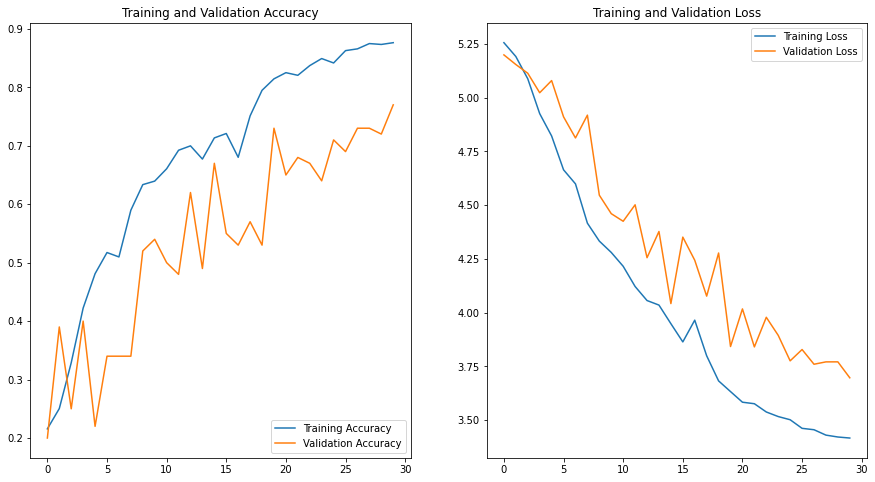

In [ ]:
history = model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Best Accuracy is Good
- Training Accuracy = 88% and Validation Accuracy = 77%
- But Model is very complex and has about **5 Million parameters and seems to Overfit**
- Let us try to replace LSTM --> GRU and see how the model performs

## Model 2: Conv2D + GRU

- Replace LSTM with GRU will reduce parameters
- Parameters reduced from 5 Million --> 4 Million

In [ ]:
batch_size=30
num_epochs=30
reset_random_seeds()

class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.SGD() 

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_history_gru = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 100, 100, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 100, 100, 32)  0        
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 10, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 10, 49, 49, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 49, 49, 32)  

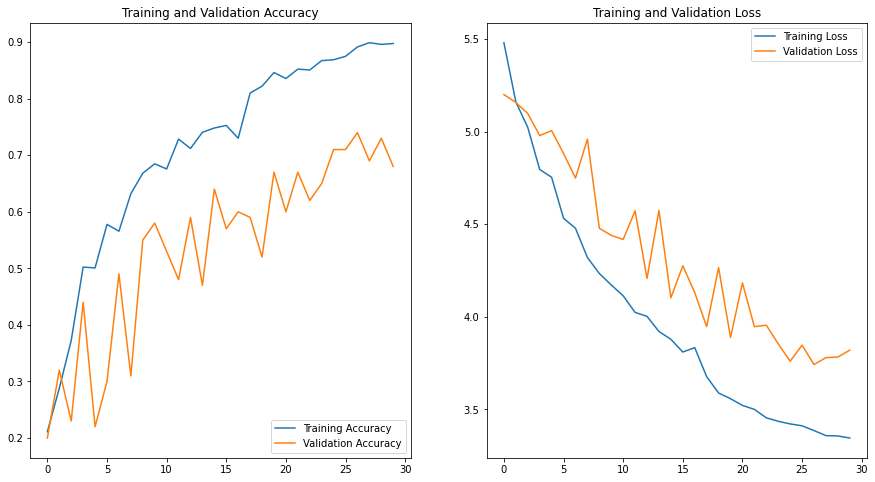

In [ ]:
history = model_history_gru
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Best Training Accuracy: 90% and Validation Accuracy:68%
- Model Overfit as the epochs progressed
- Let us decrease the number of parameters so that the model becomes more generalizable
- Also increase the epochs so that the model will learn slowly with decreased parameters

## Model 3: Conv2D + GRU (Epochs = 40)

- Model Parameters reduced from **4 Million --> 1 Million**
- Number of Epochs are increased from **30 --> 50**

In [ ]:
batch_size=30
num_epochs=50
reset_random_seeds()

class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(Dense(16, activation='relu'))
        cnn_model.add(Dropout(.2))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.SGD() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_history_epoch50 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, 10, 100, 100, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 10, 100, 100, 32)  0        
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 10, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 10, 49, 49, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 10, 49, 49, 32)  

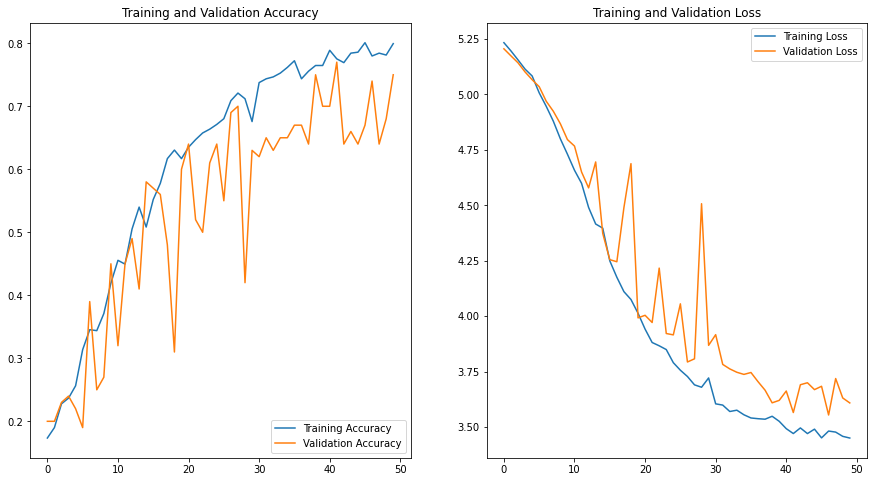

In [ ]:
history = model_history_epoch50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- This Approach of Decreasing parameters and increasing epochs gave interesting results
- Parameters are reduced to 1/4th.
- Best Training Accuracy: 80% and Validation Accuracy: 75%.
- Accuracy decreased a little.
- Let us increase batch size and see how it impacts the model training.

## Model 4: Conv2D + GRU (Epochs = 40, Batch Size = 60)

In [ ]:
batch_size=60
num_epochs=40
reset_random_seeds()

class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(Dense(16, activation='relu'))
        cnn_model.add(Dropout(.2))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.SGD() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_history_btsize60 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_63 (TimeDi  (None, 10, 100, 100, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 10, 100, 100, 32)  0        
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 10, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 10, 49, 49, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 10, 49, 49, 32)  

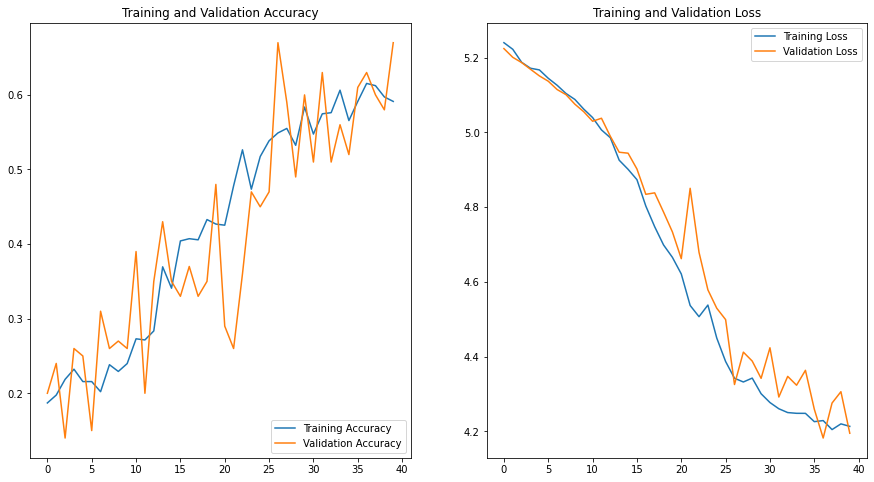

In [ ]:
history = model_history_btsize60
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning went slower across all the epochs
- Best Training Accuracy: 59% and Validation Accuracy: 67%.
- Accuracy decreased significantly
- This might be due to higher batch sizes its effect on gradients
- For now, batch_size=30 seems to be the better model
- Let us try data augmentation on similar settings and see if the model underfit rectifies.

## Model 5: Conv2D + GRU (Epochs = 40, Batch Size = 60) + Data Augmentation

In [ ]:
batch_size=60
num_epochs=40
reset_random_seeds()
image_x_shape = 100
image_y_shape = 100

train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)



class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(Dense(16, activation='relu'))
        cnn_model.add(Dropout(.2))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.SGD() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_history_btsize60_aug = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_105 (TimeD  (None, 10, 100, 100, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_106 (TimeD  (None, 10, 100, 100, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, 10, 49, 49, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_108 (TimeD  (None, 10, 49, 49, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_109 (TimeD  (None, 10, 49, 49, 32)  

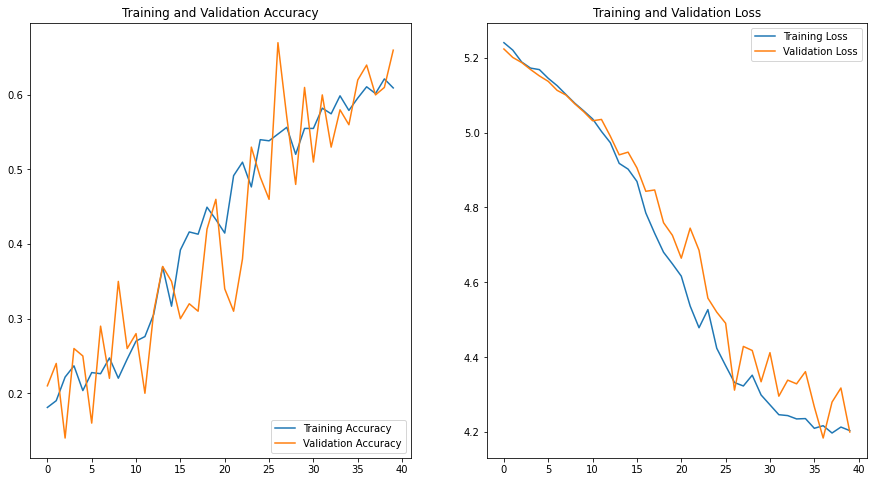

In [ ]:
history = model_history_btsize60_aug
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning is having a lot of flucations still
- Data Augmentation did not help accuracy significantly
- Training Accuracy=61% & Validation Accuracy=66%
- Model is still underfitting
- Let us try to increase the image size and see if the model captures features better

### Model 6: Conv2D + GRU  (Epochs = 40, Batch Size = 60, Img=(160,160))  + Data Augmentation

In [ ]:
batch_size=60
num_epochs=40
reset_random_seeds()
image_x_shape = 160
image_y_shape = 160

train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)


class Convolution2DWithGRU():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        cnn_model = Sequential()
        cnn_model.add(TimeDistributed(Conv2D(32, (1, 1), padding='same'), input_shape=(10, image_x_shape, image_y_shape, 3)))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3), strides = (2,2))))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        cnn_model.add(TimeDistributed(BatchNormalization()))
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        
        cnn_model.add(TimeDistributed(MaxPooling2D((3, 3))))
        
        cnn_model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same')))
        cnn_model.add(TimeDistributed(Activation('relu')))
        
        cnn_model.add(Dropout(0.25))
        
        cnn_model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        cnn_model.add(Dropout(0.50))
        
        cnn_model.add(TimeDistributed(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))))
        cnn_model.add(TimeDistributed(Activation('relu')))

        
        cnn_model.add(TimeDistributed(Flatten()))
        cnn_model.add(Dense(16, activation='relu'))
        cnn_model.add(Dropout(.2))
        cnn_model.add(GRU(64, return_sequences=False))
        cnn_model.add(Dropout(.2))
        cnn_model.add(Dense(5, activation='softmax'))
        return cnn_model

obj = Convolution2DWithGRU()
model = obj.model(batch_size)
optimiser = optimizers.SGD() #write your optimizer

model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
early_stopping = EarlyStopping(patience=3)        

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [checkpoint,reduceLR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model_history_btsize60_aug_img60 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_126 (TimeD  (None, 10, 160, 160, 32)  128      
 istributed)                                                     
                                                                 
 time_distributed_127 (TimeD  (None, 10, 160, 160, 32)  0        
 istributed)                                                     
                                                                 
 time_distributed_128 (TimeD  (None, 10, 79, 79, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_129 (TimeD  (None, 10, 79, 79, 32)   128       
 istributed)                                                     
                                                                 
 time_distributed_130 (TimeD  (None, 10, 79, 79, 32)  

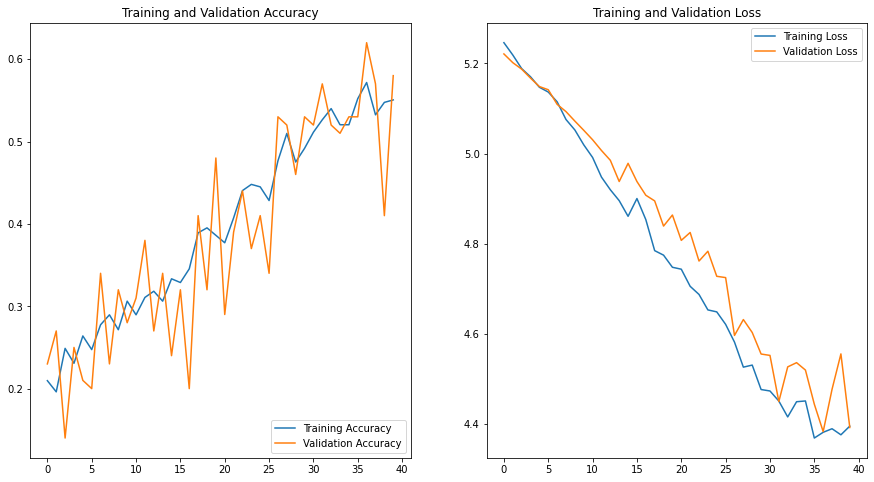

In [ ]:
history = model_history_btsize60_aug_img60
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning is having a lot of flucations still
- Training Accuracy=55% & Validation Accuracy=58%
- Let us try a different architecture and see how it fares.

## Conv3D Model: 

## Model 7: Conv3D + SGD 

In [ ]:
class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 100
image_y_shape = 100

train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.SGD() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 50, 50, 8)     0         
 )                                                               
                                                                 
 batch_normalization_21 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 25, 25, 16)    0         
 3D)                                                             
                                                      

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:

conv3d_model_history = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 30
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 3.9372 - accuracy: 0.2051Source path =  ./Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2022-04-1100_04_13.386502/model_3d-00001-3.93719-0.20513-3.54039-0.20000.h5
23/23 [==============================] - 75s 3s/step - loss: 3.9372 - accuracy: 0.2051 - val_loss: 3.5404 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 3.7418 - accuracy: 0.2157
Epoch 2: saving model to model_init_2022-04-1100_04_13.386502/model_3d-00002-3.74179-0.21569-3.53478-0.22000.h5
23/23 [==============================] - 73s 3s/step - loss: 3.7418 - accuracy: 0.2157 - val_loss: 3.5348 - val_accuracy: 0.2200 - lr: 0.0100
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 3.6762 - accuracy: 0.2383
Epoch 3: saving model to model_init_2022-04-1100_04_13.386502/model_3d-00003-3.67617-0.23831-3.52175-0.3

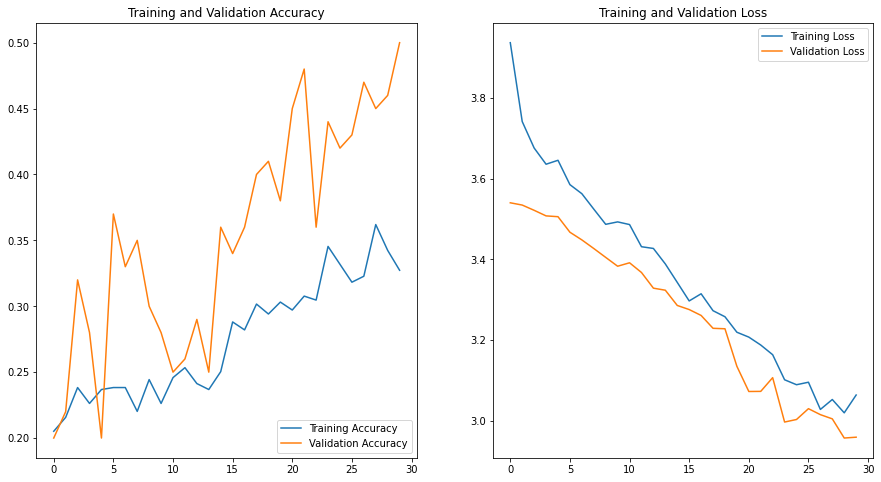

In [ ]:
history = conv3d_model_history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning is having a lot of flucations
- Model parameters are just 0.3 Million
- This might be due to optimizer. 
- But let us do a few more experiments before changing optimizer.
- Training Accuracy=33% & Validation Accuracy=50%
- Model is underfitting so let us try data augmentation

## Model 8: Conv3D + SGD + Data Augmentation

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 100
image_y_shape = 100


train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.SGD() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

conv3d_model_history_sgd_aug = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 50, 50, 8)     0         
 3D)                                                             
                                                                 
 batch_normalization_27 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 25, 25, 16)    0         
 3D)                                                             
                                                      

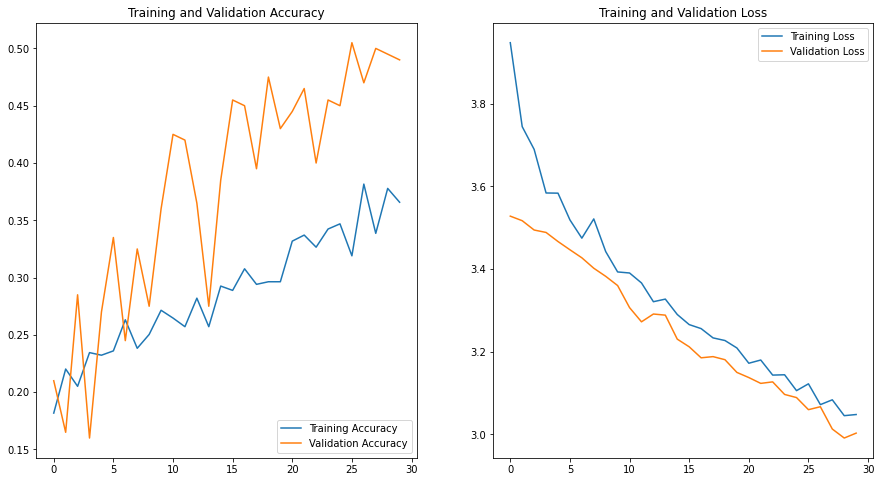

In [ ]:
history = conv3d_model_history_sgd_aug
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning is having a lot of flucations
- Data Augmentation did not help much
- Training Accuracy=37% & Validation Accuracy=49%
- Model is underfitting
- Let us increase image size and see if we can capture more features

## Model 9: Conv3D + SGD + Data Augmentation + Imagesize 160

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 160
image_y_shape = 160


train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.SGD() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

conv3d_model_history_sgd_aug_160 = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 80, 80, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 5, 80, 80, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 2, 40, 40, 16)    0         
 g3D)                                                            
                                                      

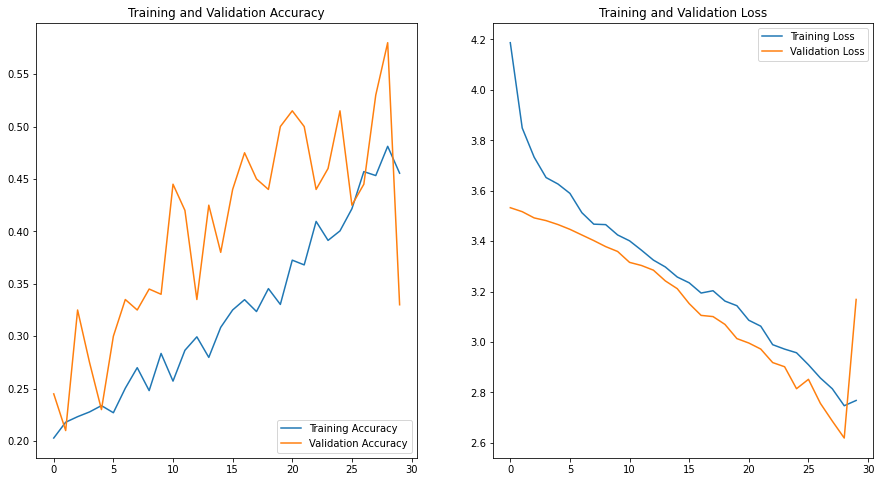

In [ ]:
history = conv3d_model_history_sgd_aug_160
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model Learning is also having a lot of flucations
- Image size increase helped to rise accuracy a little bit
- Training Accuracy=46% & Validation Accuracy=33%
- Model is still underfitting
- Let us go ahead and change the optimizer to ADAM

## Model 10: Conv3D + ADAM Optimizer

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 100
image_y_shape = 100


train_generator = generator(train_path, train_doc, batch_size,augment=False)
val_generator = generator(val_path, val_doc, batch_size,augment=False)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

conv3d_model_history_adam = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_45 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                            
                                                     

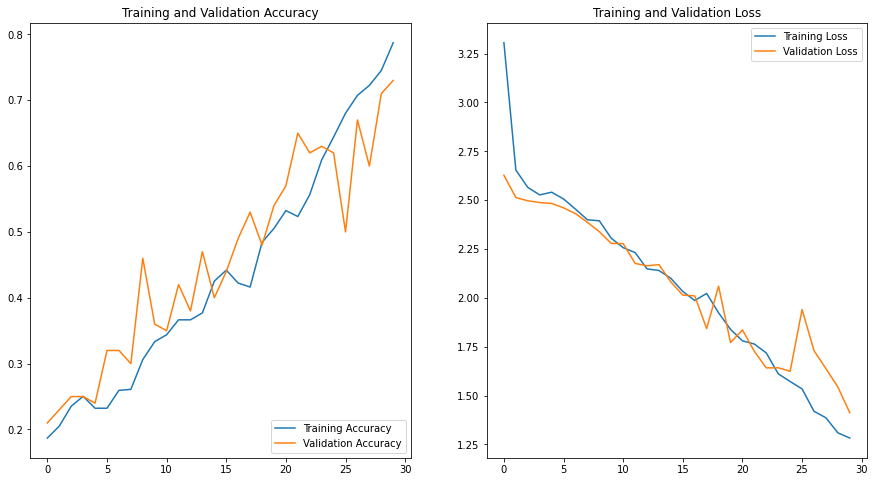

In [ ]:
history = conv3d_model_history_adam
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Fluctuations decreased a little
- Accuracy improved significantly
- Training Accuracy=79% & Validation Accuracy=73%
- Let us try data augmentation on same model

## Model 11: Conv3D + ADAM + Data Augmentation

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 100
image_y_shape = 100


train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, 100, 100, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

conv3d_model_history_adam_aug = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 100, 100, 8)   656       
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_39 (Bat  (None, 5, 50, 50, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 50, 50, 16)     3472      
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 2, 25, 25, 16)    0         
 g3D)                                                            
                                                     

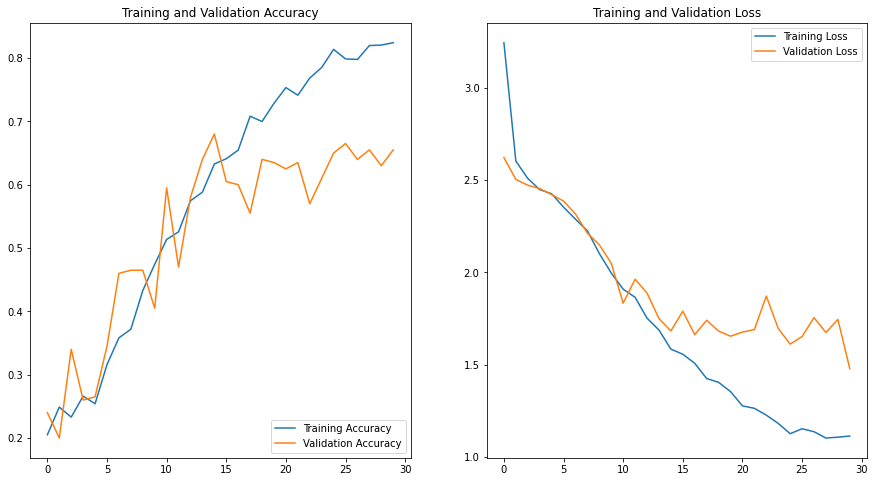

In [ ]:
history = conv3d_model_history_adam_aug
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Model is training properly
- Training Accuracy=82% & Validation Accuracy=66%
- Let us try increase image size to improve accuracy furthur

## Model 12: Conv3D + ADAM + Data Augmentation (ImageSize=160)

In [ ]:
reset_random_seeds()
batch_size=30
num_epochs=30
image_x_shape = 160
image_y_shape = 160


train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

conv3d_model_history_adam_aug_160 = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 80, 80, 8)     0         
 )                                                               
                                                                 
 batch_normalization_3 (Batc  (None, 5, 80, 80, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 40, 40, 16)    0         
 3D)                                                             
                                                      

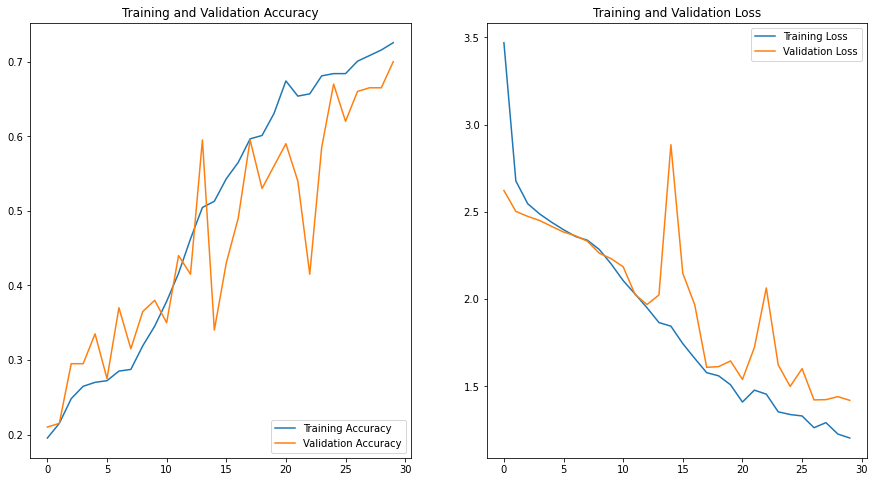

In [ ]:
history = conv3d_model_history_adam_aug_160
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Training Accuracy=73% & Validation Accuracy=70%
- Model can converge more if we try for more epochs maybe

## Model 13: Conv3D + ADAM + Data Augmentation (ImageSize=160, Epochs=50) 

In [20]:
reset_random_seeds()
batch_size=30
num_epochs=50
image_x_shape = 160
image_y_shape = 160


train_generator = generator(train_path, train_doc, batch_size,augment=True)
val_generator = generator(val_path, val_doc, batch_size,augment=True)

class convolution3D():
    def __init__(self):
        return None
    
    def model(self, batch_size):
        model = Sequential()
      
        model.add(Conv3D(8, kernel_size=(3, 3, 3),activation='relu', padding="same",input_shape=(10, image_x_shape, image_y_shape, 3)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(32, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        
        model.add(MaxPooling3D(pool_size=(2, 2, 1),data_format='channels_first'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, kernel_size=(3, 3, 3),activation='relu', padding="same",
                         kernel_regularizer=regularizers.l2(0.01),
                        bias_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling3D(pool_size=(2, 2, 2),data_format='channels_first'))
        model.add(BatchNormalization())
        
       
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64,activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(5, activation='softmax'))
        return model


obj = convolution3D()
conv3d_model = obj.model(batch_size)
conv3d_optimiser = optimizers.Adam() #write your optimizer

conv3d_model.compile(optimizer=conv3d_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (conv3d_model.summary())

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_3d-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks_list = [reduceLR,checkpoint]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

conv3d_model_history_adam_aug_160_ep50 = conv3d_model.fit(train_generator,
                                           steps_per_epoch=steps_per_epoch,
                                           epochs=num_epochs,
                                           verbose=1,
                                           callbacks=callbacks_list,
                                           validation_data=val_generator,
                                           validation_steps=validation_steps,
                                           class_weight=None,
                                           workers=1,
                                           initial_epoch=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 80, 80, 8)     0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 5, 80, 80, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 40, 40, 16)    0         
 3D)                                                             
                                                      

In [25]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
conv3d_model.save('./PROJECT/Final_Gesture_Recognition_model.h5')

In [26]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('./PROJECT/Final_Gesture_Recognition_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 160, 160, 8)   656       
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 5, 80, 80, 8)     0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 5, 80, 80, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 80, 80, 16)     3472      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 2, 40, 40, 16)    0         
 3D)                                                             
                                                      

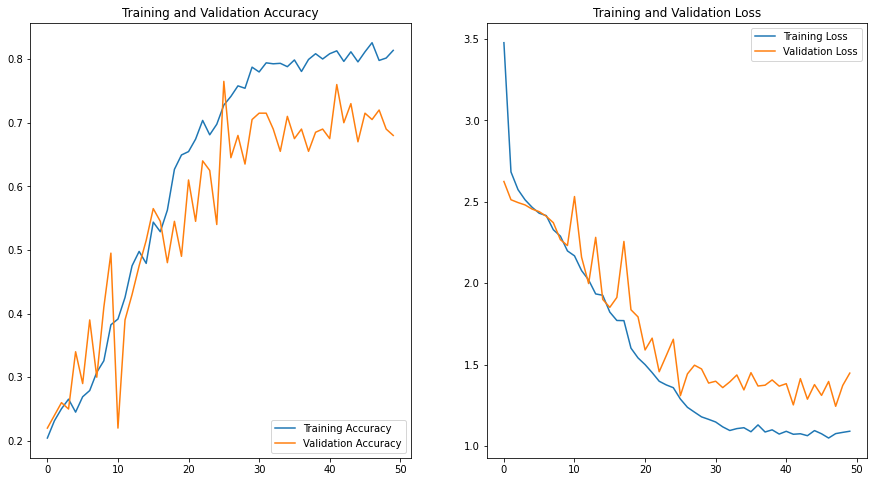

In [27]:
history = conv3d_model_history_adam_aug_160_ep50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference:

- Training Accuracy=81% & Validation Accuracy=68%
- This is our best and final model
- Parameters are just 0.4 Million
- We achieved similar accuracy as that of 5 Million parameters Model is just 0.4 Million Parameters

## Write Up Document and Conclusion

<table dir="ltr" style="float: left;" border="1" cellspacing="0" cellpadding="0"><colgroup><col width="108" /><col width="146" /><col width="163" /><col width="158" /><col width="203" /></colgroup>
<tbody>
<tr>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Experiment No&quot;}">Experiment No</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model&quot;}">Model</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Properties&quot;}">Properties</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Result&quot;}">Result</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Decision + Explanation&quot;}">Decision + Explanation</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:1}">1</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + LSTM&quot;}">Conv2D + LSTM</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = False\nepochs = 30\nParameters = 5 Million\nOptimizer = SGD&quot;}">img size = 100,100<br />batch_size = 30<br />Augmentation = False<br />epochs = 30<br />Parameters = 5 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=88%\n\nValidation Accuracy=77%&quot;}">Training Accuracy=88%<br /><br />Validation Accuracy=77%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Used LSTM because it is gives better accuracy but it also takes more parameters.\n\nLet us use GRU and see how the model performs&quot;}">Used LSTM because it is gives better accuracy but it also takes more parameters.<br /><br />Let us use GRU and see how the model performs</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:2}">2</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + GRU&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:9,&quot;2&quot;:{&quot;5&quot;:1}}">Conv2D + GRU</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = False\nepochs = 30\nParameters = 4 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:68,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:90}">img size = 100,100<br />batch_size = 30<br />Augmentation = False<br />epochs = 30<br />Parameters = 4 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=90%\n\nValidation Accuracy=68%&quot;}">Training Accuracy=90%<br /><br />Validation Accuracy=68%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Accuracy is on par with LSTM\n\nLet us try to decrease more parameters and train for more epochs as parameters reduced&quot;}">Accuracy is on par with LSTM<br /><br />Let us try to decrease more parameters and train for more epochs as parameters reduced</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:3}">3</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + GRU&quot;}">Conv2D + GRU (Epochs = 40)</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = False\nepochs = 50\nParameters = 1 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:56,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:90}">img size = 100,100<br />batch_size = 30<br />Augmentation = False<br />epochs = 50<br />Parameters = 1 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=80%\n\nValidation Accuracy=75%&quot;}">Training Accuracy=80%<br /><br />Validation Accuracy=75%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Parameters are reduced to 1/4th.\nAccuracy decreased a little.\nIncreased epochs as the model parameters has reduced.\nLet us increase batch size and see how it impacts the model training.&quot;}">Parameters are reduced to 1/4th.<br />Accuracy decreased a little.<br />Increased epochs as the model parameters has reduced.<br />Let us increase batch size and see how it impacts the model training.</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:4}">4</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + GRU&quot;}">Conv2D + GRU (Epochs = 40, Batch Size = 60)</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 60\nAugmentation = False\nepochs = 40\nParameters = 1 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:19,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:34}{&quot;1&quot;:56,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:67}">img size = 100,100<br />batch_size = 60<br />Augmentation = False<br />epochs = 40<br />Parameters = 1 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=59%\n\nValidation Accuracy=67%&quot;}">Training Accuracy=59%<br /><br />Validation Accuracy=67%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Accuracy reduced significantly.\nMaybe due to batching of gradients.\nBatch=30 seems to the better.\nLet us try data augmentation to see if the model underfit rectifies.&quot;}">Accuracy reduced significantly.<br />Maybe due to batching of gradients.<br />Batch=30 seems to the better.<br />Let us try data augmentation to see if the model underfit rectifies.</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:5}">5</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + GRU&quot;}">Conv2D + GRU (Epochs = 40, Batch Size = 60) + Data Augmentation</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 60\nAugmentation = True\nepochs = 40\nParameters = 1 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:35,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:54}">img size = 100,100<br />batch_size = 60<br />Augmentation = True<br />epochs = 40<br />Parameters = 1 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=61%\n\nValidation Accuracy=66%&quot;}">Training Accuracy=61%<br /><br />Validation Accuracy=66%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Data Augmentation did not help accuracy significantly.\nModel is underfitting.\nLet us try to increase the image size and see if the model captures features better.&quot;}">Data Augmentation did not help accuracy significantly.<br />Model is underfitting.<br />Let us try to increase the image size and see if the model captures features better.</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:6}">6</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv2D + GRU&quot;}">Conv2D + GRU (Epochs = 40, Batch Size = 60, Img=(160,160)) + Data Augmentation</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 160,160\nbatch_size = 60\nAugmentation = True\nepochs = 40\nParameters = 1 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:18}">img size = 160,160<br />batch_size = 60<br />Augmentation = True<br />epochs = 40<br />Parameters = 1 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=55%\n\nValidation Accuracy=58%&quot;}">Training Accuracy=55%<br /><br />Validation Accuracy=58%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Improving image size improved accuracy slightly.\n\nLet us try a different architecture and see how it fares.&quot;}">Improving image size improved accuracy slightly.<br /><br />Let us try a different architecture and see how it fares.</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7}">7</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = False\nepochs = 30\nParameters = 0.3 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:68,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:92}">img size = 100,100<br />batch_size = 30<br />Augmentation = False<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=33%\n\nValidation Accuracy=50%&quot;}">Training Accuracy=33%<br /><br />Validation Accuracy=50%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model Learning is having a lot of flucations.\nThis might be due to optimizer.\nBut let us do a few more experiments before changing optimizer.\nModel is underfitting so let us try data augmentation&quot;}">Model Learning is having a lot of flucations.<br />This might be due to optimizer.<br />But let us do a few more experiments before changing optimizer.<br />Model is underfitting so let us try data augmentation</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:8}">8</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + SGD + Data Augmentation</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = True\nepochs = 30\nParameters = 0.3 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:35,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:54}">img size = 100,100<br />batch_size = 30<br />Augmentation = True<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=37%\n\nValidation Accuracy=49%&quot;}">Training Accuracy=37%<br /><br />Validation Accuracy=49%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model Learning is having a lot of flucations.\nData Augmentation did not help much.\nModel is underfitting.\nLet us increase image size and see if we can capture more features.&quot;}">Model Learning is having a lot of flucations.<br />Data Augmentation did not help much.<br />Model is underfitting.<br />Let us increase image size and see if we can capture more features.</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9}">9</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + SGD + Data Augmentation + Imagesize 160</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 160,160\nbatch_size = 30\nAugmentation = True\nepochs = 30\nParameters = 0.3 Million\nOptimizer = SGD&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:18}">img size = 160,160<br />batch_size = 30<br />Augmentation = True<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = SGD</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=46%\n\nValidation Accuracy=33%&quot;}">Training Accuracy=46%<br /><br />Validation Accuracy=33%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model is still underfitting\n\nLearning is fluctuating\nLet us change the optimizer to ADAM and run the same experiments&quot;}">Model is still underfitting<br /><br />Learning is fluctuating<br />Let us change the optimizer to ADAM and run the same experiments</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:10}">10</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + ADAM Optimizer</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = False\nepochs = 30\nParameters = 0.3 Million\nOptimizer = ADAM&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:18}{&quot;1&quot;:35,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:55}{&quot;1&quot;:93,&quot;2&quot;:{&quot;5&quot;:1}}">img size = 100,100<br />batch_size = 30<br />Augmentation = False<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = ADAM</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=79%\n\nValidation Accuracy=73%&quot;}">Training Accuracy=79%<br /><br />Validation Accuracy=73%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Fluctuation decreased\nAccuracy improved significantly\nlet us add data augmentation and see how the model behaves&quot;}">Fluctuation decreased<br />Accuracy improved significantly<br />let us add data augmentation and see how the model behaves</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:11}">11</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + ADAM + Data Augmentation</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 100,100\nbatch_size = 30\nAugmentation = True\nepochs = 30\nParameters = 0.3 Million\nOptimizer = ADAM&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:35,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:54}">img size = 100,100<br />batch_size = 30<br />Augmentation = True<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = ADAM</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=82%\n\nValidation Accuracy=66%&quot;}">Training Accuracy=82%<br /><br />Validation Accuracy=66%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model is training properly\n\nLet us increase image size and try to furthur improve accuracy&quot;}">Model is training properly<br /><br />Let us increase image size and try to furthur improve accuracy</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:12}">12</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3DConv3D + ADAM + Data Augmentation (ImageSize=160)</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 160,160\nbatch_size = 30\nAugmentation = True\nepochs = 30\nParameters = 0.3 Million\nOptimizer = ADAM&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:18}">img size = 160,160<br />batch_size = 30<br />Augmentation = True<br />epochs = 30<br />Parameters = 0.3 Million<br />Optimizer = ADAM</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=73%\n\nValidation Accuracy=70%&quot;}">Training Accuracy=73%<br /><br />Validation Accuracy=70%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Model is still converging.\n\nLet us try for few more epochs&quot;}">Model is still converging.<br /><br />Let us try for few more epochs</td>
</tr>
<tr>
<td data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:13}">13</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Conv3D &quot;}">Conv3D + ADAM + Data Augmentation (ImageSize=160, Epochs=50)</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;img size = 160,160\nbatch_size = 30\nAugmentation = True\nepochs = 50\nParameters = 0.3 Million\nOptimizer = ADAM&quot;}" data-sheets-textstyleruns="{&quot;1&quot;:0}{&quot;1&quot;:55,&quot;2&quot;:{&quot;5&quot;:1}}{&quot;1&quot;:66}">img size = 160,160<br />batch_size = 30<br />Augmentation = True<br />epochs = 50<br />Parameters = 0.3 Million<br />Optimizer = ADAM</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Training Accuracy=81%\n\nValidation Accuracy=68%&quot;}">Training Accuracy=81%<br /><br />Validation Accuracy=68%</td>
<td data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Best Model \n\nSimilar accuracy as of 5 Million parameter Model&quot;}">Best Model <br /><br />Similar accuracy as of 5 Million parameter Model</td>
</tr>
</tbody>
</table>